In [1]:
#     Exploratory Data Analysis of Skin Lesion Dataset
#     Copyright (C) 2024  Sebastián A. Cruz Romero

#     This program is free software: you can redistribute it and/or modify
#     it under the terms of the GNU General Public License as published by
#     the Free Software Foundation, either version 3 of the License, or
#     (at your option) any later version.

#     This program is distributed in the hope that it will be useful,
#     but WITHOUT ANY WARRANTY; without even the implied warranty of
#     MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
#     GNU General Public License for more details.

### Import Libraries

In [2]:
import os
import sys
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
import torch
import cv2 as cv
from PIL import Image
from tqdm import tqdm
from torchinfo import summary
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

### Utils

In [3]:
def get_image_paths(root_dir, extensions=['.jpg', '.png', '.jpeg']):
    """
    Get a list of all image file paths in the root_dir with specified extensions.
    
    Parameters:
    root_dir (str): Root directory to search for image files.
    extensions (list): List of file extensions to include.
    
    Returns:
    list: List of image file paths.
    """
    image_paths = []
    for ext in extensions:
        # Recursively search for files with the given extension
        image_paths.extend(glob.glob(os.path.join(root_dir, '**', f'*{ext}'), recursive=True))
    return image_paths

def save_paths_to_csv(image_paths, csv_file):
    """
    Save image file paths to a CSV file using pandas.
    
    Parameters:
    image_paths (list): List of image file paths.
    csv_file (str): Path to the CSV file where paths will be saved.
    """
    # Create a DataFrame with a single column 'Image Path'
    df = pd.DataFrame(image_paths, columns=['Image Path'])
    # Save the DataFrame to a CSV file
    df.to_csv(csv_file, index=False)

def plot_image_grid(df, image_column='image_path', class_column='class', grid_size=(10, 10), image_size=(300, 300)):
    """
    Plots a grid of images from a DataFrame.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing image paths and their respective classes.
    image_column (str): Column name in the DataFrame that contains image paths.
    class_column (str): Column name in the DataFrame that contains image classes.
    grid_size (tuple): Size of the grid (rows, cols).
    image_size (tuple): Size to which each image will be resized (width, height).
    
    Returns:
    None
    """
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(15, 15))
    axes = axes.flatten()

    for i, (idx, row) in enumerate(df.iterrows()):
        if i >= grid_size[0] * grid_size[1]:
            break
        img_path = row[image_column]
        img_class = row[class_column]
        
        # Read and resize the image
        img = cv.imread(img_path)
        if img is None:
            print(f"Error loading image at {img_path}")
            continue
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        img = cv.resize(img, image_size)
        
        # Plot the image
        axes[i].imshow(img)
        axes[i].set_title(f"Type: {img_class}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

def image_features(df, image_column='image_path'):
    """
    Adds image pixel values as features to the DataFrame and normalizes them.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing image paths.
    image_column (str): Column name in the DataFrame that contains image paths.
    
    Returns:
    pd.DataFrame: DataFrame with image pixel values added as new columns, normalized between 0 and 1.
    """
    # Initialize a list to hold the image pixel values
    image_features = []

    for idx, row in df.iterrows():
        img_path = row[image_column]
        
        # Read and resize the image
        img = cv.imread(img_path)
        if img is None:
            print(f"Error loading image at {img_path}")
            continue
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        
        # Normalize the image array
        img_normalized = img / 255.0
        
        # Flatten the normalized image array and add it to the list
        img_flattened = img_normalized.flatten()
        image_features.append(img_flattened)
    
    # Convert the list of image features to a DataFrame
    image_features_df = pd.DataFrame(image_features)
    df = pd.concat([df.reset_index(drop=True), image_features_df.reset_index(drop=True)], axis=1)
    
    return df 

def generate_mask(df):
    """
    Generate and display a mask for an image with lesion outlines.

    Parameters:
    df (pd.DataFrame): DataFrame containing image paths and classes.

    Returns:
    None
    """
    # Sample an image from the DataFrame
    img = df.sample()
    title = img['Neoplasm Type'].item()

    # Load image from path
    image_path = img['Image Path'].item()
    image = Image.open(image_path).convert("RGB")
    image_np = np.array(image)

    # Generate mask using a simple thresholding technique
    gray_image = cv.cvtColor(image_np, cv.COLOR_RGB2GRAY)
    _, mask = cv.threshold(gray_image, 127, 255, cv.THRESH_BINARY_INV)

    # Find contours
    contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    # Draw contours on the original image
    outlined_image = image_np.copy()
    cv.drawContours(outlined_image, contours, -1, (255, 0, 0), 2)  # Draw in red with thickness 2

    # Display images
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f'{title} - Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(outlined_image)
    plt.title(f'{title} - Image with Lesion Outline')
    plt.axis('off')

    plt.show()

In [4]:
import torch
from torch.utils.data import Dataset
from sklearn.metrics import log_loss, mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

class PerformanceMetrics(Dataset):
    def __init__(self, predicted, actual):
        self.predicted = predicted.detach().cpu()
        self.actual = actual.detach().cpu()

        print(self.predicted, self.actual)
        
    def performancemetrics(self, predicted, actual):
        acc = round(accuracy_score(actual, predicted), 3)
        precision = round(precision_score(actual, predicted), 3)
        recall = round(recall_score(actual, predicted), 3)
        f1score = round(f1_score(actual, predicted), 3)

        log = round(log_loss(actual, predicted), 3) # cross entropy loss

        fpr, tpr, thr = roc_curve(actual, predicted)
        auc = roc_auc_score(actual, predicted)

        cmatrix = confusion_matrix(actual, predicted).ravel()
        tn, fp, fn, tp = cmatrix

        cmatrix_df = pd.DataFrame(data=[tp, fp, tn, fn],
                                    index=['True Positive', 'False Positive', 'True Negative', 
                                        'False Negative'],
                                    columns=['Confusion Matrix'])
        
        met_df = pd.DataFrame(data=[acc, precision, recall, f1score, log, fpr, tpr, auc],
                                    index=['Accuracy','Precision', 'Recall', 'F1 Score',
                                        'Cross Entropy', 'False Positive Rate', 
                                        'True Positive Rate', 'Area Under the Curve'], 
                                    columns=['Performance Metrics'])
        return met_df, cmatrix_df
    
# y_pred, y_validate = np.array([[0],[1],[1],[0],[1]]), np.array([[1],[1],[1],[0],[1]])
    
# functiontest = PerformanceMetrics(y_pred, y_validate)
# metrics_df, cmatrix_df = functiontest.performancemetrics(functiontest.predicted, functiontest.actual)
# display(metrics_df)
# display(cmatrix_df)

### Model Architecture

In [5]:
# Define any data augmentations or transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=np.random.rand()),
    transforms.RandomVerticalFlip(p=np.random.rand()),
    transforms.RandomRotation(degrees=np.random.randint(0,360)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.605, 0.605, 0.605], std=[0.231, 0.231, 0.231])
])


# Create datasets from CSV files (assuming you have a custom dataset class)
class SkinCancerImageDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx, 0]
        image = Image.open(img_name)
        label = str(self.data.iloc[idx, 1])
        target = int(self.data.iloc[idx, 2])
        if self.transform:
            image = self.transform(image)
        return image, target

train_dataset = SkinCancerImageDataset(csv_file='../data/train.csv', transform=transform)
test_dataset = SkinCancerImageDataset(csv_file='../data/test.csv', transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [6]:
device = torch.device('cpu')

# Check for macOS Apple Silicon compatibility
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")
else:
    device = torch.device("mps")


In [7]:
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    size = len(dataloader.dataset)
    batch_losses = []
    batch_acc = []

    for batch_idx, (X, y) in tqdm(enumerate(dataloader), total=len(dataloader), desc="Training"):
        X, y = X.to(device), y.to(device).unsqueeze(1)
        y = y.to(torch.float32)
        
        optimizer.zero_grad()
        pred = model(X)

        # print(pred.dtype, pred.shape, pred)
        # print(y.dtype, y.shape, y)
        loss = loss_fn(pred, y)        
        loss.backward()
        optimizer.step()

        # scores = PerformanceMetrics(pred, y)
        # metrics_df, cmatrix_df = scores.performancemetrics(scores.predicted, scores.actual)
        
        batch_losses.append(loss.item())
        predicted = (pred > 0.5).float()
        correct = (predicted == y).sum().item()
        accuracy = correct / y.size(0)
        batch_acc.append(accuracy)
    
    avg_loss = sum(batch_losses) / len(batch_losses)
    avg_accuracy = sum(batch_acc) / len(batch_acc)


    print(f"Avg Loss: {avg_loss:.4f}, Avg Accuracy: {avg_accuracy:.4f}")

    return avg_loss, avg_accuracy#, metrics_df, cmatrix_df

def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    batch_losses = []
    batch_acc = []

    with torch.no_grad():
        # for batch_idx, (X, y) in tqdm(enumerate(dataloader), total=len(dataloader), desc="Testing"):
        for batch_idx, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device).unsqueeze(1)
            y = y.to(torch.float32)

            pred = model(X)
            loss = loss_fn(pred, y)

            # scores = PerformanceMetrics(pred, y)
            # metrics_df, cmatrix_df = scores.performancemetrics(scores.predicted, scores.actual)

            batch_losses.append(loss.item())
            predicted = (pred > 0.5).float()
            correct = (predicted == y).sum().item()
            accuracy = correct / y.size(0)
            batch_acc.append(accuracy)
    
    avg_loss = sum(batch_losses) / len(batch_losses)
    avg_accuracy = sum(batch_acc) / len(batch_acc)

    # print(f"Avg Loss: {avg_loss:.4f}, Avg Accuracy: {avg_accuracy:.4f}")

    return avg_loss, avg_accuracy#, metrics_df, cmatrix_df


In [8]:
class NCNet(nn.Module):
    def __init__(self):
        super(NCNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 8, 3)

        self.fc1 = nn.Linear(8 * 14 * 14, 120)
        self.fc2 = nn.Linear(120, 32)
        self.fc3 = nn.Linear(32, 1)
        # self.threshold = nn.Threshold(0.5, 0)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        x = torch.flatten(x, 1) # flatten all dimensions except batch
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        # x = torch.sigmoid(x)
        # x = self.threshold(x)
        x = x.to(torch.float32)
        return x

model = NCNet()
print(summary(model, (16, 3, 64, 64)))

Layer (type:depth-idx)                   Output Shape              Param #
NCNet                                    [16, 1]                   --
├─Conv2d: 1-1                            [16, 16, 62, 62]          448
├─MaxPool2d: 1-2                         [16, 16, 31, 31]          --
├─Conv2d: 1-3                            [16, 8, 29, 29]           1,160
├─MaxPool2d: 1-4                         [16, 8, 14, 14]           --
├─Linear: 1-5                            [16, 120]                 188,280
├─Linear: 1-6                            [16, 32]                  3,872
├─Linear: 1-7                            [16, 1]                   33
Total params: 193,793
Trainable params: 193,793
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 46.24
Input size (MB): 0.79
Forward/backward pass size (MB): 8.75
Params size (MB): 0.78
Estimated Total Size (MB): 10.31


In [9]:
# Initialize model, loss function, and optimizer
model = NCNet()
model = model.to(device)

loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

EPOCHS=25

epoch_losses = []
epoch_acc = []

for epoch in range(EPOCHS):
    print(f"[======================= Epoch {epoch + 1}/{EPOCHS} =======================]")
    # avg_loss, avg_accuracy, metrics, cmatrix, aucroc = train_loop(train_loader, model, loss_fn, optimizer)
    avg_loss, avg_accuracy = train_loop(train_loader, model, loss_fn, optimizer)
    epoch_losses.append(avg_loss)
    epoch_acc.append(avg_accuracy)
print("\n[ Finished Training! ]")

[======================= Epoch 1/25 =======================]


Training: 100%|██████████| 601/601 [00:12<00:00, 49.39it/s]


Avg Loss: 0.3776, Avg Accuracy: 0.8199
[======================= Epoch 2/25 =======================]


Training: 100%|██████████| 601/601 [00:11<00:00, 52.51it/s]


Avg Loss: 0.3214, Avg Accuracy: 0.8561
[======================= Epoch 3/25 =======================]


Training: 100%|██████████| 601/601 [00:10<00:00, 54.86it/s]


Avg Loss: 0.2980, Avg Accuracy: 0.8637
[======================= Epoch 4/25 =======================]


Training: 100%|██████████| 601/601 [00:11<00:00, 54.62it/s]


Avg Loss: 0.2832, Avg Accuracy: 0.8736
[======================= Epoch 5/25 =======================]


Training: 100%|██████████| 601/601 [00:10<00:00, 58.64it/s]


Avg Loss: 0.2800, Avg Accuracy: 0.8786
[======================= Epoch 6/25 =======================]


Training: 100%|██████████| 601/601 [00:10<00:00, 55.60it/s]


Avg Loss: 0.2706, Avg Accuracy: 0.8808
[======================= Epoch 7/25 =======================]


Training: 100%|██████████| 601/601 [00:10<00:00, 55.51it/s]


Avg Loss: 0.2650, Avg Accuracy: 0.8851
[======================= Epoch 8/25 =======================]


Training: 100%|██████████| 601/601 [00:10<00:00, 56.46it/s]


Avg Loss: 0.2590, Avg Accuracy: 0.8827
[======================= Epoch 9/25 =======================]


Training: 100%|██████████| 601/601 [00:10<00:00, 56.43it/s]


Avg Loss: 0.2562, Avg Accuracy: 0.8862
[======================= Epoch 10/25 =======================]


Training: 100%|██████████| 601/601 [00:10<00:00, 57.00it/s]


Avg Loss: 0.2486, Avg Accuracy: 0.8900
[======================= Epoch 11/25 =======================]


Training: 100%|██████████| 601/601 [00:10<00:00, 57.36it/s]


Avg Loss: 0.2502, Avg Accuracy: 0.8899
[======================= Epoch 12/25 =======================]


Training: 100%|██████████| 601/601 [00:10<00:00, 56.67it/s]


Avg Loss: 0.2441, Avg Accuracy: 0.8921
[======================= Epoch 13/25 =======================]


Training: 100%|██████████| 601/601 [00:10<00:00, 56.58it/s]


Avg Loss: 0.2428, Avg Accuracy: 0.8949
[======================= Epoch 14/25 =======================]


Training: 100%|██████████| 601/601 [00:10<00:00, 54.81it/s]


Avg Loss: 0.2375, Avg Accuracy: 0.8975
[======================= Epoch 15/25 =======================]


Training: 100%|██████████| 601/601 [00:10<00:00, 55.75it/s]


Avg Loss: 0.2352, Avg Accuracy: 0.8988
[======================= Epoch 16/25 =======================]


Training: 100%|██████████| 601/601 [00:10<00:00, 56.23it/s]


Avg Loss: 0.2342, Avg Accuracy: 0.9000
[======================= Epoch 17/25 =======================]


Training: 100%|██████████| 601/601 [00:10<00:00, 56.94it/s]


Avg Loss: 0.2310, Avg Accuracy: 0.9000
[======================= Epoch 18/25 =======================]


Training: 100%|██████████| 601/601 [00:10<00:00, 56.42it/s]


Avg Loss: 0.2271, Avg Accuracy: 0.9017
[======================= Epoch 19/25 =======================]


Training: 100%|██████████| 601/601 [00:10<00:00, 57.33it/s]


Avg Loss: 0.2285, Avg Accuracy: 0.9000
[======================= Epoch 20/25 =======================]


Training: 100%|██████████| 601/601 [00:10<00:00, 58.08it/s]


Avg Loss: 0.2232, Avg Accuracy: 0.9036
[======================= Epoch 21/25 =======================]


Training: 100%|██████████| 601/601 [00:10<00:00, 58.00it/s]


Avg Loss: 0.2248, Avg Accuracy: 0.9049
[======================= Epoch 22/25 =======================]


Training: 100%|██████████| 601/601 [00:10<00:00, 55.97it/s]


Avg Loss: 0.2235, Avg Accuracy: 0.9027
[======================= Epoch 23/25 =======================]


Training: 100%|██████████| 601/601 [00:10<00:00, 56.81it/s]


Avg Loss: 0.2250, Avg Accuracy: 0.9021
[======================= Epoch 24/25 =======================]


Training: 100%|██████████| 601/601 [00:10<00:00, 56.58it/s]


Avg Loss: 0.2192, Avg Accuracy: 0.9062
[======================= Epoch 25/25 =======================]


Training: 100%|██████████| 601/601 [00:10<00:00, 57.26it/s]

Avg Loss: 0.2164, Avg Accuracy: 0.9066

[ Finished Training! ]


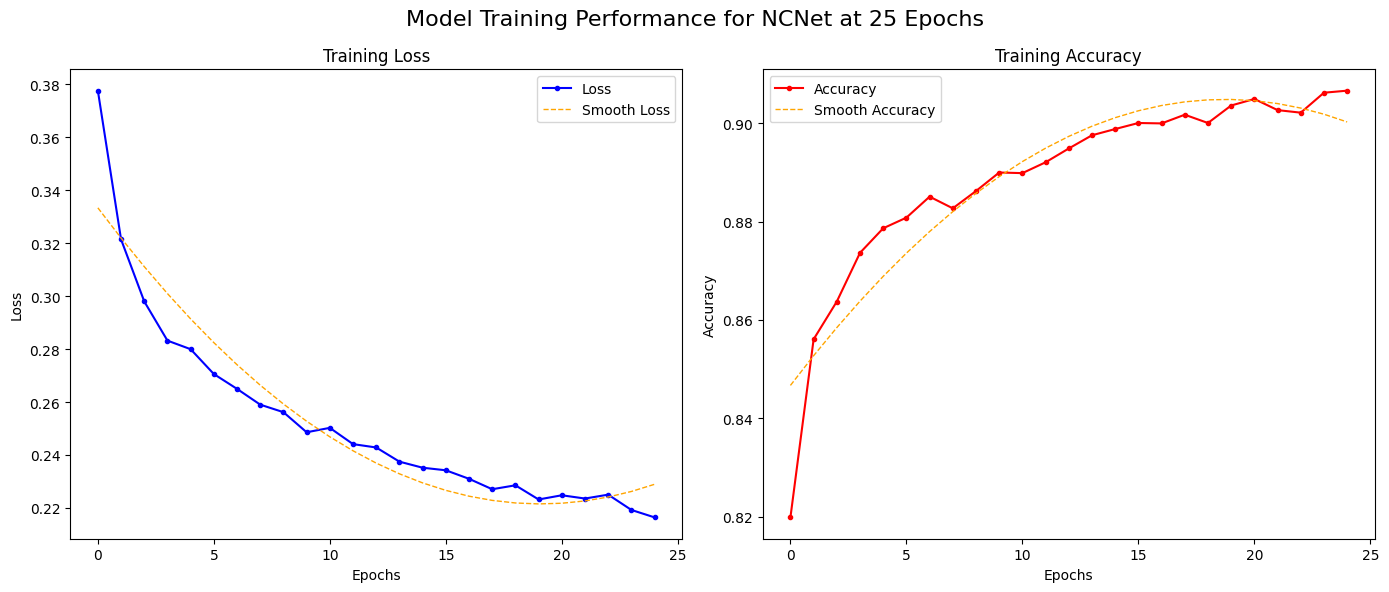

In [10]:
# Create subplots
# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot training loss with smooth trend line
x = np.arange(len(epoch_losses))
z = np.polyfit(x, epoch_losses, 2)  # Fit a 2nd degree polynomial
p = np.poly1d(z)
ax1.plot(x, epoch_losses, marker='.', linestyle='-', color='b', label='Loss')
ax1.plot(x, p(x), color='orange', linestyle='--', linewidth=1, label='Smooth Loss')
ax1.set_title('Training Loss')
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend()

# Plot training accuracy with smooth trend line
x = np.arange(len(epoch_acc))
z = np.polyfit(x, epoch_acc, 2)  # Fit a 2nd degree polynomial
p = np.poly1d(z)
ax2.plot(x, epoch_acc, marker='.', linestyle='-', color='r', label='Accuracy')
ax2.plot(x, p(x), color='orange', linestyle='--', linewidth=1, label='Smooth Accuracy')
ax2.set_title('Training Accuracy')
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.legend()

# Add a header title for the entire figure
fig.suptitle(f'Model Training Performance for NCNet at {EPOCHS} Epochs', fontsize=16)

plt.tight_layout()
plt.show()

In [11]:
# # test_loss, test_accuracy, metrics, cmatrix, aucroc = test_loop(test_loader, model, loss_fn)
test_epoch_losses = []
test_epoch_acc = []

for k in range(100):
    if k % 10 == 0:
        print(f"[======================= Random Iterations {k}/100 =======================]")
    # avg_loss, avg_accuracy, metrics, cmatrix, aucroc = train_loop(train_loader, model, loss_fn, optimizer)
    test_loss, test_accuracy = test_loop(test_loader, model, loss_fn)
    test_epoch_losses.append([k, test_loss])
    test_epoch_acc.append([k, test_accuracy])

test_epoch_losses_df = pd.DataFrame(test_epoch_losses, columns=['k', 'Best Loss']).sort_values(by='Best Loss', ascending=True)[:10].set_index('k')
test_epoch_acc_df = pd.DataFrame(test_epoch_acc, columns=['k', 'Best Accuracy']).sort_values(by='Best Accuracy', ascending=False)[:10].set_index('k')

display(test_epoch_losses_df, test_epoch_acc_df)

[======================= Random Iterations 0/100 =======================]
[======================= Random Iterations 10/100 =======================]
[======================= Random Iterations 20/100 =======================]
[======================= Random Iterations 30/100 =======================]
[======================= Random Iterations 40/100 =======================]
[======================= Random Iterations 50/100 =======================]
[======================= Random Iterations 60/100 =======================]
[======================= Random Iterations 70/100 =======================]
[======================= Random Iterations 80/100 =======================]
[======================= Random Iterations 90/100 =======================]


,Best Loss
k,
81,0.239143
38,0.239261
77,0.239619
72,0.239933
58,0.240361
64,0.240428
34,0.240613
14,0.240788
26,0.240944


,Best Accuracy
k,
59,0.895833
17,0.895833
89,0.894841
97,0.893849
34,0.893849
90,0.893849
36,0.893849
0,0.892857
25,0.892857
